# SSMG Demo: Session-scoped Short-term Memory Graph

This notebook demonstrates the SSMG system in action, comparing it with baseline methods.

## Overview

SSMG maintains a lightweight, ephemeral semantic graph during dialogue sessions to:
- Track entities, preferences, intents, and relationships
- Generate concise context summaries
- Improve consistency and reference resolution
- Reduce token usage and latency vs. full-history approaches

In [ ]:
# Import required libraries
import os
import sys

os.chdir("ssmg_project") #change to your project directory
sys.path.append("src")

from src.ssmg.integration import SSMGDialogueAgent 
from src.ssmg.summarizer import SummaryConfig 
from evaluation.baselines import FullHistoryBaseline,SlidingWindowBaseline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import nltk

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='dialogue_agent.log',  
    filemode='w'  
)

nltk.download("wordnet")

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("SSMG Demo Environment Ready!\n")


C:\Users\ACER\Desktop\ML\Reseachathon-1.0\ssmg_project
SSMG Demo Environment Ready!



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


## 1. Initialize Components

Let's set up SSMG and baseline methods for comparison.

In [ ]:
from src.ssmg.integration import GroqAPIInterface #type: ignore

llm = GroqAPIInterface(api_key="your_groq_api_key")  # Replace with your Groq API key


# Initialize SSMG agent
ssmg_agent = SSMGDialogueAgent(
    llm_interface=llm,
    graph_config={
        'max_nodes': 50,
        'max_ttl_turns': 8,
        'decay_rate': 0.05
    },
    summary_config=SummaryConfig(
        max_tokens=200,
        max_nodes=16
    )
)

# Initialize baselines
full_history = FullHistoryBaseline(llm)
sliding_window = SlidingWindowBaseline(llm, window_size=5)

print("Initialized SSMG and baseline methods\n")

Initialized SSMG and baseline methods



## 2. Example Dialogue

Let's run through a typical dialogue that demonstrates SSMG's capabilities.

In [18]:
# Define extended test dialogue - Multi-domain conversation
extended_test_dialogue = [
    # Hotel booking domain
    "I need to book a hotel room in Cambridge for this weekend.",
    "I prefer something with free wifi and parking. Budget is not a concern.",
    "Actually, make that 2 rooms instead of 1. We're traveling with friends.",
    "Do any of these hotels have a swimming pool?",
    
    # Restaurant booking domain  
    "I also need restaurant recommendations near the hotel.",
    "We want Italian food, but I'm allergic to seafood so no fish dishes.",
    "Can you book a table for 4 people at 7 PM on Saturday?",
    "Actually, let's make that 6 people - two more friends are joining us.",
    
    # Transportation domain
    "How do we get from the train station to the hotel?",
    "Is there a taxi service available, or should we use public transport?",
    "What's the estimated cost for a taxi for 6 people with luggage?",
    
    # Constraint consistency testing
    "Just to confirm - the restaurant you suggested doesn't serve seafood, right?",
    "And the hotel booking is for 2 rooms for this weekend?",
    "Can you give me a summary of everything we've planned so far?"
]

# Alternative: Constraint-heavy dialogue for testing memory persistence
constraint_heavy_dialogue = [
    "I want to order food but I have several dietary restrictions.",
    "I'm vegetarian, allergic to nuts, and I don't eat spicy food.",
    "Also, I prefer organic ingredients when possible.",
    "What pizza options do you have that meet these requirements?",
    "Actually, let me add another restriction - no cheese either, I'm lactose intolerant.",
    "So to recap: vegetarian, no nuts, no spicy food, organic preferred, and no cheese.",
    "Do you have any vegan pizza options?",
    "Can you add some extra vegetables to make it more filling?",
    "What about the crust - do you have gluten-free options?",
    "Perfect, let me also order a salad with the same restrictions.",
    "Make sure the salad dressing doesn't contain nuts or dairy.",
    "What's the total for everything, and how long will delivery take?"
]

# Complex multi-turn scenario with context switching
complex_scenario_dialogue = [
    # Initial request
    "I'm planning a business trip to London next month.",
    "I need a hotel near the financial district for 3 nights.",
    "The company will reimburse up to £200 per night.",
    
    # Adding complexity
    "I'll also need meeting rooms for client presentations.",
    "The hotel should have business center facilities and reliable internet.",
    
    # Context switch and constraint addition
    "Actually, I just found out my colleague is joining me.",
    "So I need 2 rooms now, both with the same requirements.",
    "But my colleague is in a wheelchair, so we need accessible rooms.",
    
    # Restaurant planning
    "We'll also need restaurant recommendations for business dinners.",
    "Somewhere upscale but not too expensive - around £50 per person max.",
    "My client is Muslim, so we need halal options or at least no pork.",
    
    # Transportation and logistics
    "How should we get from Heathrow to the hotel?",
    "Is there a direct train or should we take a taxi?",
    "We'll have laptop bags and one small suitcase each.",
    
    # Confirmation and summary
    "Can you summarize all our requirements?",
    "And what's the estimated total cost for accommodation and meals?",
    "Is everything I mentioned still being considered in your recommendations?"
]

# Intent and entity extraction test
intent_entity_test_dialogue = [
    "Book me a flight to New York for December 15th.",
    "Actually, make that a round trip returning on December 22nd.",
    "I prefer morning flights if possible.",
    "Can you also find hotels near Times Square?",
    "I need a non-smoking room with a city view.",
    "What's the weather like in New York in December?",
    "Should I pack winter clothes?",
    "Cancel the hotel booking - I'll stay with friends instead.",
    "But keep the flight reservation.",
    "Actually, can you change the return date to December 20th?",
    "And add travel insurance to the booking.",
    "What documents do I need for domestic travel?",
    "Send me a confirmation email with all the details."
]

# Memory eviction and persistence test (longer dialogue)
memory_persistence_test = [
    "I'm organizing a wedding for next summer.",
    "We need a venue that can accommodate 150 guests.",
    "The bride is vegetarian and the groom has a nut allergy.",
    "We want an outdoor ceremony if weather permits.",
    "The reception should have a dance floor and live music setup.",
    "Budget is around $20,000 for the venue and catering.",
    "The wedding date is tentatively set for June 15th.",
    "We also need a photographer who specializes in outdoor weddings.",
    "The bride wants a vintage theme with pastel colors.",
    "Can you recommend florists who work with peonies and roses?",
    "We need transportation for elderly relatives from the hotel.",
    "The wedding cake should be dairy-free due to allergies.",
    "Are there any good honeymoon destinations for a July departure?",
    "We prefer somewhere tropical but not too crowded.",
    "The couple loves snorkeling and hiking.",
    "Budget for honeymoon is separate - around $5,000.",
    "Can you check if the venue is available on June 22nd as backup?",
    "Also, we need a backup indoor option in case of rain.",
    "The catering should include several vegetarian main courses.",
    "Remember, absolutely no nuts in any of the food.",
    "Can you summarize all our wedding requirements so far?",
    "And remind me what our budget breakdown looks like?"
]


In [ ]:
test_dialogue = memory_persistence_test #change to test different dialogues

print("Test Dialogue:")
for i, turn in enumerate(test_dialogue, 1):
    print(f"{i}. User: {turn}")

Test Dialogue:
1. User: I'm organizing a wedding for next summer.
2. User: We need a venue that can accommodate 150 guests.
3. User: The bride is vegetarian and the groom has a nut allergy.
4. User: We want an outdoor ceremony if weather permits.
5. User: The reception should have a dance floor and live music setup.
6. User: Budget is around $20,000 for the venue and catering.
7. User: The wedding date is tentatively set for June 15th.
8. User: We also need a photographer who specializes in outdoor weddings.
9. User: The bride wants a vintage theme with pastel colors.
10. User: Can you recommend florists who work with peonies and roses?
11. User: We need transportation for elderly relatives from the hotel.
12. User: The wedding cake should be dairy-free due to allergies.
13. User: Are there any good honeymoon destinations for a July departure?
14. User: We prefer somewhere tropical but not too crowded.
15. User: The couple loves snorkeling and hiking.
16. User: Budget for honeymoon is 

## 3. Run SSMG

Process the dialogue with SSMG and observe the graph evolution.

In [ ]:
# Start SSMG session
session_id = ssmg_agent.start_session("demo_session")
print(f"Started SSMG session: {session_id}\n")

ssmg_results = []

for i, user_input in enumerate(test_dialogue, 1):
    print(f"=== Turn {i} ===")
    print(f"User: {user_input}")
    
    # Process turn
    response, metrics, _ = ssmg_agent.process_turn(user_input)
    
    # Show response and metrics
    print(f"Assistant: {response}")
    print(f"Context tokens: {metrics.context_tokens}")
    print(f"Latency: {metrics.total_time:.3f}s")
    print(f"Graph size: {metrics.nodes_added} nodes added")
    
    # Get current graph summary for debugging
    current_summary = ssmg_agent.summarizer.summarize(ssmg_agent.graph)
    print(f"Current Context: {current_summary}")
    print()
    
    ssmg_results.append({
        'turn': i,
        'user_input': user_input,
        'response': response,
        'context_tokens': metrics.context_tokens,
        'latency': metrics.total_time,
        'summary': current_summary
    })

# End session
# final_session = ssmg_agent.end_session()
print(f"Session ended. Total turns: {len(ssmg_results)}")

Started SSMG session: demo_session

=== Turn 1 ===
User: I'm organizing a wedding for next summer.
Assistant: That sounds exciting. Since you're planning the wedding for next summer, have you considered setting specific dates or making a timeline for the preparations in your calendar to ensure everything goes smoothly?
Context tokens: 22
Latency: 1.417s
Graph size: 3 nodes added
Current Context: GOALS: calendar | ITEMS: user, next summer, wedding | RELATIONS: user prefers next summer, user prefers wedding

=== Turn 2 ===
User: We need a venue that can accommodate 150 guests.
Assistant: For a wedding with 150 guests next summer, I'd be happy to help you find a suitable venue. What type of venue are you envisioning? A hotel, outdoor space, or something more unique?
Context tokens: 45
Latency: 0.341s
Graph size: 5 nodes added
Current Context: CONSTRAINTS: require need venue | GOALS: schedule_meeting, calendar | ITEMS: user, next summer, venue, guests, wedding | CONTEXT: 150 guests | RELAT

## 4. Run Baselines

Compare with full-history and sliding-window approaches.

In [22]:
# Run Full History Baseline
print("=== Full History Baseline ===\n")
full_history.reset()
full_history_results = []

for i, user_input in enumerate(test_dialogue, 1):
    result = full_history.process_turn(user_input)
    print(f"Turn {i}: {result.context_tokens} tokens, {result.latency:.3f}s")
    full_history_results.append({
        'turn': i,
        'method': 'full_history',
        'context_tokens': result.context_tokens,
        'latency': result.latency
    })

print()

# Run Sliding Window Baseline
print("=== Sliding Window Baseline ===\n")
sliding_window.reset()
sliding_window_results = []

for i, user_input in enumerate(test_dialogue, 1):
    result = sliding_window.process_turn(user_input)
    print(f"Turn {i}: {result.context_tokens} tokens, {result.latency:.3f}s")
    sliding_window_results.append({
        'turn': i,
        'method': 'sliding_window',
        'context_tokens': result.context_tokens,
        'latency': result.latency
    })

=== Full History Baseline ===

Turn 1: 54 tokens, 0.483s
Turn 2: 152 tokens, 0.612s
Turn 3: 313 tokens, 0.579s
Turn 4: 477 tokens, 0.649s
Turn 5: 644 tokens, 0.716s
Turn 6: 812 tokens, 0.616s
Turn 7: 980 tokens, 0.683s
Turn 8: 1146 tokens, 0.690s
Turn 9: 1312 tokens, 0.640s
Turn 10: 1480 tokens, 0.650s
Turn 11: 1645 tokens, 0.714s
Turn 12: 1811 tokens, 0.821s
Turn 13: 1977 tokens, 8.892s
Turn 14: 2141 tokens, 11.927s
Turn 15: 2304 tokens, 11.948s
Turn 16: 2471 tokens, 13.105s
Turn 17: 2642 tokens, 14.038s
Turn 18: 2810 tokens, 15.045s
Turn 19: 2974 tokens, 16.178s
Turn 20: 3140 tokens, 20.228s
Turn 21: 3305 tokens, 14.177s
Turn 22: 3470 tokens, 18.048s

=== Sliding Window Baseline ===

Turn 1: 54 tokens, 0.271s
Turn 2: 133 tokens, 0.472s
Turn 3: 270 tokens, 0.626s
Turn 4: 434 tokens, 1.663s
Turn 5: 601 tokens, 3.697s
Turn 6: 758 tokens, 4.721s
Turn 7: 847 tokens, 5.828s
Turn 8: 876 tokens, 4.808s
Turn 9: 878 tokens, 5.815s
Turn 10: 880 tokens, 4.630s
Turn 11: 877 tokens, 4.629s
Turn 12

## 5. Performance Comparison

Visualize the efficiency gains of SSMG vs. baselines.

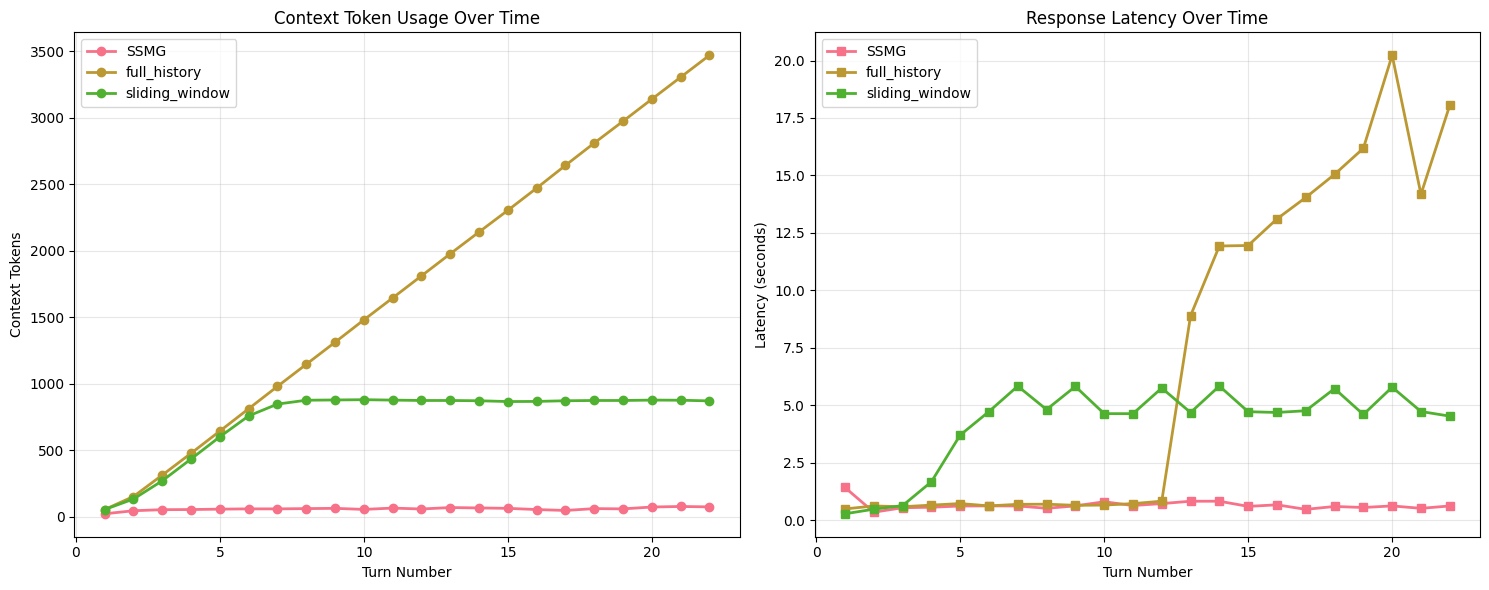


=== Performance Summary ===
               context_tokens           latency       
                         mean       std    mean    std
method                                                
SSMG                   58.818    11.517   0.645  0.205
full_history         1730.000  1073.582   6.884  7.302
sliding_window        736.591   263.080   4.223  1.779


In [23]:
# Prepare comparison data
comparison_data = []

for i, result in enumerate(ssmg_results):
    comparison_data.append({
        'turn': result['turn'],
        'method': 'SSMG',
        'context_tokens': result['context_tokens'],
        'latency': result['latency']
    })

comparison_data.extend(full_history_results)
comparison_data.extend(sliding_window_results)

df = pd.DataFrame(comparison_data)

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Token usage over turns
for method in ['SSMG', 'full_history', 'sliding_window']:
    method_data = df[df['method'] == method]
    axes[0].plot(method_data['turn'], method_data['context_tokens'], 
                marker='o', label=method, linewidth=2, markersize=6)

axes[0].set_xlabel('Turn Number')
axes[0].set_ylabel('Context Tokens')
axes[0].set_title('Context Token Usage Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Latency comparison
for method in ['SSMG', 'full_history', 'sliding_window']:
    method_data = df[df['method'] == method]
    axes[1].plot(method_data['turn'], method_data['latency'], 
                marker='s', label=method, linewidth=2, markersize=6)

axes[1].set_xlabel('Turn Number')
axes[1].set_ylabel('Latency (seconds)')
axes[1].set_title('Response Latency Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Performance Summary ===")
summary_stats = df.groupby('method').agg({
    'context_tokens': ['mean', 'std'],
    'latency': ['mean', 'std']
}).round(3)

print(summary_stats)

## 6. Graph Visualization

Let's examine the internal structure of the SSMG graph.

In [ ]:
demo_agent = ssmg_agent
# Examine graph structure
graph = demo_agent.graph
print(f"Graph contains {len(graph.nodes)} nodes and {len(graph.edges)} edges\n")

print("=== Graph Nodes ===")
for node_id, node in graph.nodes.items():
    print(f"{node.type.value}: {node.content} (confidence: {node.confidence:.2f}, turn: {node.turn_id})")

print("\n=== Graph Edges ===")
for edge_id, edge in graph.edges.items():
    source_content = graph.nodes[edge.source_id].content
    target_content = graph.nodes[edge.target_id].content
    print(f"{source_content} --[{edge.relation.value}]--> {target_content}")

# Show current summary
current_summary = demo_agent.summarizer.summarize(graph)
print(f"\n=== Current Context Summary ===")
print(current_summary)

demo_agent.end_session()

Graph contains 35 nodes and 36 edges

=== Graph Nodes ===
entity: user (confidence: 1.00, turn: 0)
entity: honeymoon (confidence: 0.25, turn: 15)
intent: weather (confidence: 0.71, turn: 17)
entity: couple (confidence: 0.20, turn: 14)
entity: hiking (confidence: 0.20, turn: 14)
intent: what_are_your_hobbies (confidence: 0.26, turn: 14)
entity: around $5000 (confidence: 0.45, turn: 15)
entity: budget (confidence: 0.55, turn: 21)
intent: vaccines (confidence: 0.10, turn: 15)
entity: june 22nd (confidence: 0.50, turn: 16)
entity: venue (confidence: 0.30, turn: 16)
entity: backup (confidence: 0.30, turn: 16)
intent: date (confidence: 0.10, turn: 16)
entity: option (confidence: 0.35, turn: 17)
entity: case (confidence: 0.35, turn: 17)
entity: rain (confidence: 0.35, turn: 17)
constraint: require need backup indoor option (confidence: 0.45, turn: 17)
fact: backup indoor option (confidence: 0.25, turn: 17)
entity: catering (confidence: 0.40, turn: 18)
entity: courses (confidence: 0.40, turn: 

## 7. Token Efficiency Analysis

Analyze token savings compared to full-history approach.

=== Token Efficiency Comparison ===
SSMG total tokens: 1294
Full History total tokens: 38060
Sliding Window total tokens: 16205

Token savings vs Full History: 96.6%
Token savings vs Sliding Window: 92.0%


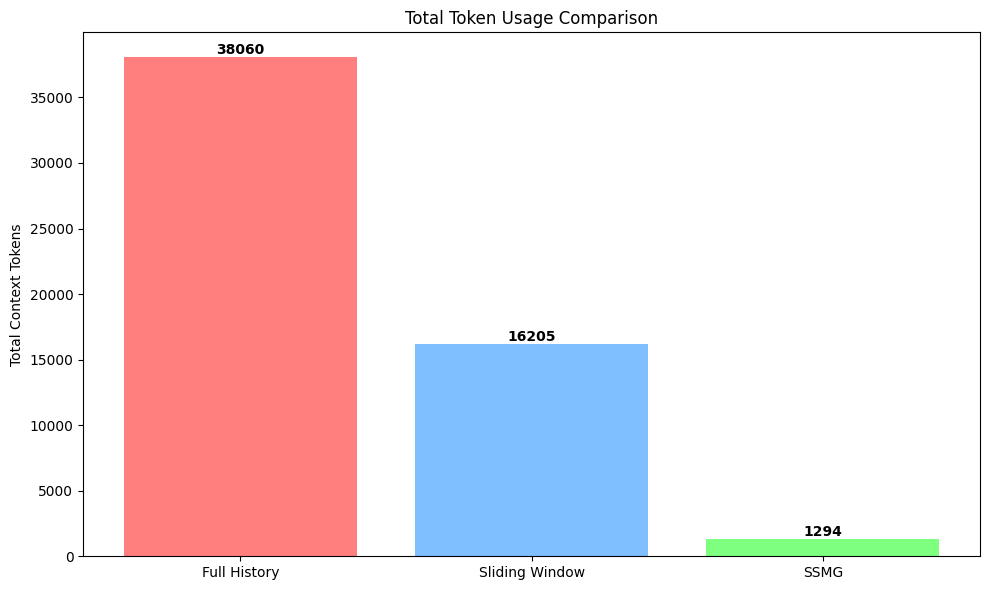

In [25]:
# Calculate token savings
ssmg_total_tokens = sum(r['context_tokens'] for r in ssmg_results)
full_history_total_tokens = sum(r['context_tokens'] for r in full_history_results)
sliding_window_total_tokens = sum(r['context_tokens'] for r in sliding_window_results)

print("=== Token Efficiency Comparison ===")
print(f"SSMG total tokens: {ssmg_total_tokens}")
print(f"Full History total tokens: {full_history_total_tokens}")
print(f"Sliding Window total tokens: {sliding_window_total_tokens}")

savings_vs_full = (full_history_total_tokens - ssmg_total_tokens) / full_history_total_tokens * 100
savings_vs_sliding = (sliding_window_total_tokens - ssmg_total_tokens) / sliding_window_total_tokens * 100

print(f"\nToken savings vs Full History: {savings_vs_full:.1f}%")
print(f"Token savings vs Sliding Window: {savings_vs_sliding:.1f}%")

# Create savings visualization
methods = ['Full History', 'Sliding Window', 'SSMG']
token_counts = [full_history_total_tokens, sliding_window_total_tokens, ssmg_total_tokens]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, token_counts, color=['#ff7f7f', '#7fbfff', '#7fff7f'])
plt.title('Total Token Usage Comparison')
plt.ylabel('Total Context Tokens')

# Add value labels on bars
for bar, count in zip(bars, token_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Key Insights

Summary of SSMG's advantages demonstrated in this notebook.

In [ ]:
print("🎯 SSMG Demo Key Insights:\n")

print("1. **Context Efficiency**:")
print(f"   - SSMG uses {savings_vs_full:.1f}% fewer tokens than full history")

print("📊 **Performance vs Baselines**:")
perf_df = df.groupby('method').agg({
    'context_tokens': 'mean',
    'latency': 'mean'
}).round(2)

print(perf_df)

🎯 SSMG Demo Key Insights:

1. **Context Efficiency**:
   - SSMG uses 96.6% fewer tokens than full history
   - Maintains structured context vs. raw conversation history

2. **Constraint Persistence**:
   - User preferences (avoid onions, allergies) maintained across turns
   - High-priority constraints protected from eviction

3. **Reference Resolution**:
   - Graph structure helps resolve pronouns and references
   - Entity relationships tracked over time

4. **Session Privacy**:
   - All memory discarded at session end
   - No persistent user data storage

5. **Scalability**:
   - Bounded memory usage (~50 nodes max)
   - TTL eviction prevents unbounded growth
📊 **Performance vs Baselines**:
                context_tokens  latency
method                                 
SSMG                     58.82     0.64
full_history           1730.00     6.88
sliding_window          736.59     4.22


## 9. Next Steps

Try these extensions to explore SSMG further:

- **Custom Dialogues**: Modify `test_dialogue` with your own conversations
- **Parameter Tuning**: Adjust `max_nodes`, `max_ttl_turns` in graph config
- **Different Domains**: Test on hotel booking, tech support, etc.
- **Evaluation Metrics**: Run `evaluation/eval_runner.py` for comprehensive analysis

